**Preprocessing the Data**

In [18]:
# Loading in all necessary libraries.

library(tidyverse)
library(tidymodels)
library(repr)
library(GGally)
options(repr.matrix.max.rows = 10)

set.seed(14)

In [174]:
# Loading in Cleveland data set

URL <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

cleveland_data <- read_csv(URL, col_names=FALSE, show_col_types = FALSE)

# Since column names aren't pre-specified, we rename them using colnames, according to the UCI repository.

colnames(cleveland_data) <- c("age", "sex", "cp", "trestbps", 
                              "chol", "fbs", "restecg", "thalach", 
                              "exang", "oldpeak", "slope", "ca", "thal", "num")
cleveland_data <- cleveland_data |>
    mutate(ca = as.numeric(ca), thal = as.numeric(thal)) |>
    filter(ca != "NA", thal != "NA")

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


In [153]:
#Adding column indicating yes or no for presence of heart disease
cl_have_disease <- cleveland_data |>
    filter(num == 1 | num == 2 | num == 3 | num == 4) |>
    mutate(hd = "yes") |>
    mutate(hd = as_factor(hd))
cl_no_disease <- cleveland_data |>
    filter(num == 0) |>
    mutate(hd = "no") |>
    mutate(hd = as_factor(hd))
cl_data_alt <- rbind(cl_have_disease, cl_no_disease)

In [154]:
# Loading in Hungarian data set

URL2 <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/reprocessed.hungarian.data"

hungarian_data <- read_delim(URL2, col_names = FALSE, delim = " ", show_col_types = FALSE)

colnames(hungarian_data) <- c("age", "sex", "cp", "trestbps", 
                              "chol", "fbs", "restecg", "thalach", 
                              "exang", "oldpeak", "slope", "ca", "thal", "num")

# Combine levels 1,2,3,4 into hd column. Levels 1-4 as "yes", level 0 as "no."
hung_have_disease <- hungarian_data |>
    filter(num == 1 | num == 2 | num == 3 | num == 4) |>
    mutate(hd = "yes") |>
    mutate(hd = as_factor(hd))
hung_no_disease <- hungarian_data |>
    filter(num == 0) |>
    mutate(hd = "no") |>
    mutate(hd = as_factor(hd))
hung_data_alt <- rbind(hung_have_disease, hung_no_disease)

In [155]:
heart_data <- rbind(hung_data_alt, cl_data_alt)
heart_data

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,hd
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
49,0,3,160,180,0,0,156,0,1.0,2,-9,-9,1,yes
48,0,4,138,214,0,0,108,1,1.5,2,-9,-9,3,yes
37,1,4,140,207,0,0,130,1,1.5,2,-9,-9,1,yes
58,1,2,136,164,0,1,99,1,2.0,2,-9,-9,3,yes
49,1,4,140,234,0,0,140,1,1.0,2,-9,-9,3,yes
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
35,1,2,122,192,0,0,174,0,0.0,1,0,3,0,no
56,1,2,130,221,0,2,163,0,0.0,1,0,7,0,no
56,1,2,120,240,0,0,169,0,0.0,3,0,3,0,no


In [156]:
# Percentages of hd (yes, no) 
num_obs_h <- nrow(heart_data)
heart_proportions <- heart_data |>
    group_by(hd) |>
    summarize(
        count = n(),
        percentage = n() / num_obs_h * 100
        )
heart_proportions

hd,count,percentage
<fct>,<int>,<dbl>
yes,243,41.11675
no,348,58.88325


In [157]:
#Creating Training and Testing Data Sets
heart_split <- initial_split(heart_data, prop = 0.75, strata = hd)
heart_training <- training(heart_split)
heart_testing <- testing(heart_split)

**Finding the Best Predictors using Forward Selection From Textbook**

Warning: Code takes 8-9 min. to run

In [160]:
#Created a duplicate set to perform Forward Selection
#Standardized this new subset
heart_subset <- heart_training |> select(-num)

#Implementing Forward Selection Code to find best predictors
names <- colnames(heart_subset |> select(-hd))

#create a tibble to store accuracies
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

#create a model spec
knn_FS_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

#create a 5-fold cross-validation object
heart_vfold <- vfold_cv(heart_subset, v = 5, strata = hd)

#store the total number of predictors
n_total <- length(names)

#stores selected predictors
selected <- c()
for (i in 1:n_total) {
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        preds_new <- c(selected, names[[j]])
        model_string <- paste("hd", "~", paste(preds_new, collapse="+"))
        heart_FS_recipe <- recipe(as.formula(model_string),
                                data = heart_subset) |>
                            step_scale(all_predictors()) |>
                            step_center(all_predictors())
        acc <- workflow() |>
            add_recipe(heart_FS_recipe) |>
            add_model(knn_FS_spec) |>
            tune_grid(resamples = heart_vfold, grid = 10) |>
            collect_metrics() |>
            filter(.metric == "accuracy") |>
            summarize(mx = max(mean))
        acc <- acc$mx |> unlist()
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |>
        add_row(size = i,
                model_string = models[[jstar]],
                accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,hd ~ oldpeak,0.7293003
2,hd ~ oldpeak+cp,0.8149796
3,hd ~ oldpeak+cp+thal,0.8329832
4,hd ~ oldpeak+cp+thal+slope,0.8397253
5,hd ~ oldpeak+cp+thal+slope+ca,0.8374526
⋮,⋮,⋮
9,hd ~ oldpeak+cp+thal+slope+ca+restecg+fbs+sex+thalach,0.8239695
10,hd ~ oldpeak+cp+thal+slope+ca+restecg+fbs+sex+thalach+trestbps,0.8261667
11,hd ~ oldpeak+cp+thal+slope+ca+restecg+fbs+sex+thalach+trestbps+exang,0.8307877


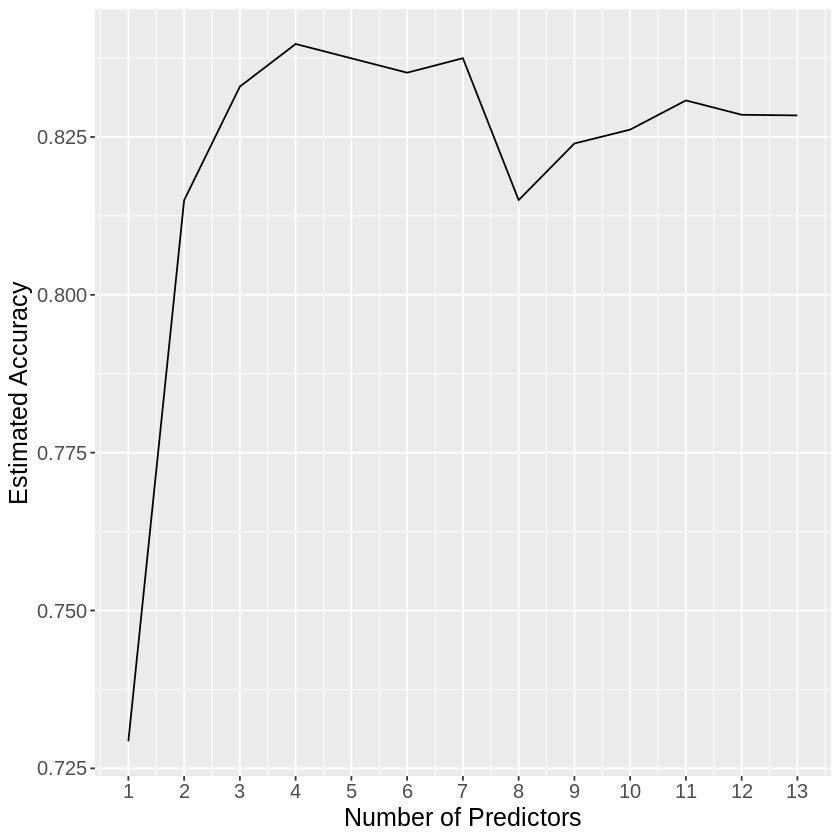

In [163]:
best_preds_plot <- ggplot(accuracies, aes(x = size, y = accuracy)) +
    geom_line() +
    xlab("Number of Predictors") +
    ylab("Estimated Accuracy") +
    scale_x_continuous(breaks = 1:13) +
    theme(text = element_text(size = 15))
best_preds_plot

In [165]:
best_preds <- accuracies |> slice(4,7)
best_preds

size,model_string,accuracy
<int>,<chr>,<dbl>
4,hd ~ oldpeak+cp+thal+slope,0.8397253
7,hd ~ oldpeak+cp+thal+slope+ca+restecg+fbs,0.8374782


Using 4 and 7 predictors produce a similar accuracy, with 4 being slightly better. Thus, the best predictors are "oldpeak", "cp", "thal", and "slope".